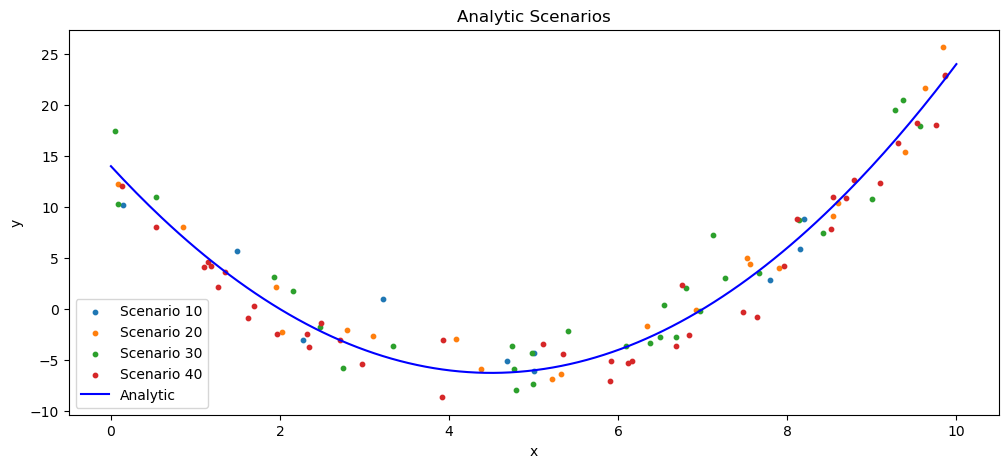

In [84]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4)

f_true = lambda x: x**2 - 9*x + 14

# Scenarios
scenarios = [10, 20, 30, 40]

seed = 79
np.random.seed(seed)

# Dictionary to store data
scenario_data = {}

# Plotting setup
plt.figure(figsize=(12, 5))

# Y_train now has a noise term
# noise follows a normal distribution N(0,2)
# this noise should also be seeded
# Process each scenario
for n in scenarios:
    # Draw from a uniform distribution randomly
    X_train = np.random.uniform(0, 10, n)
    noise = np.random.normal(0, 2, n)
    Y_train = np.array([f_true(xt) for xt in X_train]) + noise

    # Store data in the dictionary
    scenario_data[n] = (X_train, Y_train)
    plt.scatter(X_train, Y_train, label=f"Scenario {n}", s=10)

# Analytic data with 200 points
X_analytic = np.linspace(0, 10, 200)
Y_analytic = f_true(X_analytic)

plt.title("Analytic Scenarios")
plt.plot(X_analytic, Y_analytic, label="Analytic", color="blue")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


In [85]:
import GPy

# Dictionary to store GP models
gp_models = {}

for n in scenarios:
    # Retrieve training data for this scenario
    X_train, Y_train = scenario_data[n]

    # Define the kernel
    kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

    # Create the GP model
    gp_model = GPy.models.GPRegression(X_train.reshape(-1,1), Y_train.reshape(-1,1), kernel)

    # Optimize the model (find the best hyperparameters)
    gp_model.optimize(messages=True)

    # Store the optimized model
    gp_models[n] = gp_model

    # Print the optimized model's parameter values
    print(f"Model for scenario {n}:")
    print(gp_model)
    print("\n")


Model for scenario 10:

Name : GP regression
Objective : 28.69099114154535
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |   36.95274085408896  |      +ve      |        
  rbf.lengthscale          |  0.7371073908922338  |      +ve      |        
  Gaussian_noise.variance  |   2.203451140548869  |      +ve      |        




Model for scenario 20:

Name : GP regression
Objective : 53.89130360555217
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |   228.5252322070741  |      +ve      |        
  rbf.lengthscale          |  1.8334123680476695  |      +ve      |        
  Gaussian_noise.variance  |  2.2589660957949023  |      +ve      |        




Model for scenario 30:

Name : GP regression
Objective : 79.90186394189018
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |   989.2925354967854  |      +ve      |        
  rbf.lengthscale          |  5.9802014533888705  |      +ve      |        
  Gaussian_noise.variance  |   5.941852901476522  |      +ve      |        




Model for scenario 40:

Name : GP regression
Objective : 94.33110696214342
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |  362.71080227018484  |      +ve      |        
  rbf.lengthscale          |   3.197649230372177  |      +ve      |        
  Gaussian_noise.variance  |  3.1678373400133926  |      +ve      |        




### Boxplots

Validation set $n=10^5$

Validation metric: $$ \epsilon_{gen} \approx \frac{\sum_{i=1}^{n} (Y_i - \hat{Y}_i)^2}{\sum_{i=1}^{n} (Y_i - \mu)^2} $$

In [86]:
def perform_analysis(n_validation, metric_functions, f_true, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Generate validation data
    # seed the random x's, if None don't seed
    X_validation = np.random.uniform(0, 10, n_validation)
    Y_validation = f_true(X_validation)
    X_validation_reshaped = X_validation.reshape(-1, 1)
    # mu_Y_validation = np.mean(Y_validation)

    # Dictionary to store predictions and errors
    predictions = {}
    metrics = {}

    # Iterate over each model and evaluate
    for n, gp_model in gp_models.items():
        # Predict using the model
        Y_pred, Y_var = gp_model.predict(X_validation_reshaped)
        Y_pred = Y_pred.flatten()

        # Calculate the standard deviation of the residuals
        sigma_vs = calculate_ermse(Y_validation, Y_pred.flatten(), _)
        metrics[n] = {}

        # Calculate the error using the provided metric function
        for (metric_num, metric_function) in enumerate(metric_functions):
            metric = metric_function(Y_validation, Y_pred, sigma_vs)
            metrics[n][metric_num+1] = metric

        # Store results
        predictions[n] = Y_pred

    return X_validation, predictions, metrics

# Metric functions
def calculate_ermse(Y_validation, Y_pred, _):
    return np.sqrt(np.mean((Y_pred.flatten() - Y_validation) ** 2))

def calculate_nmae(Y_validation, Y_pred, ermse):
    max_absolute_error = np.max(np.abs(Y_pred.flatten() - Y_validation))
    return max_absolute_error / ermse

In [87]:
# Number of seeds and validation data points
num_seeds = 50
seeds = np.random.choice(range(10000), size=num_seeds, replace=False)
n_validation = 10**5

# Store the results for each seed
all_metrics = {seed: {} for seed in seeds}
all_predictions = {}
all_X_validations = {}

# Run the analysis for each seed
for seed in seeds:
    X_validation, predictions, metrics = perform_analysis(
        n_validation, [calculate_ermse, calculate_nmae], f_true, seed=seed
    )
    all_X_validations[seed] = X_validation
    all_predictions[seed] = predictions
    all_metrics[seed] = metrics

    # Print the errors for each scenario with this seed
    for n, error in metrics.items():
        print(f"Generalization Error for scenario {n} with seed {seed}: {error}")


Generalization Error for scenario 10 with seed 7531: {1: 5.84191170151192, 2: 3.9786082906136784}
Generalization Error for scenario 20 with seed 7531: {1: 0.9643557722375244, 2: 2.18971391748833}
Generalization Error for scenario 30 with seed 7531: {1: 1.0814669720251544, 2: 2.1412571281494652}
Generalization Error for scenario 40 with seed 7531: {1: 0.931536097892274, 2: 1.8172675808435417}
Generalization Error for scenario 10 with seed 8819: {1: 5.820853508750932, 2: 3.9922068497362115}
Generalization Error for scenario 20 with seed 8819: {1: 0.9660299670364717, 2: 2.1859189962025156}
Generalization Error for scenario 30 with seed 8819: {1: 1.081405730402139, 2: 2.140066434948736}
Generalization Error for scenario 40 with seed 8819: {1: 0.9315702253325786, 2: 1.8178604284080007}
Generalization Error for scenario 10 with seed 1752: {1: 5.8262454388543485, 2: 3.989050224099244}
Generalization Error for scenario 20 with seed 1752: {1: 0.9650106530772101, 2: 2.1882279249410748}
Generaliz

In [88]:
all_metrics

{7531: {10: {1: 5.84191170151192, 2: 3.9786082906136784},
  20: {1: 0.9643557722375244, 2: 2.18971391748833},
  30: {1: 1.0814669720251544, 2: 2.1412571281494652},
  40: {1: 0.931536097892274, 2: 1.8172675808435417}},
 8819: {10: {1: 5.820853508750932, 2: 3.9922068497362115},
  20: {1: 0.9660299670364717, 2: 2.1859189962025156},
  30: {1: 1.081405730402139, 2: 2.140066434948736},
  40: {1: 0.9315702253325786, 2: 1.8178604284080007}},
 1752: {10: {1: 5.8262454388543485, 2: 3.989050224099244},
  20: {1: 0.9650106530772101, 2: 2.1882279249410748},
  30: {1: 1.081374190809066, 2: 2.141017561359649},
  40: {1: 0.9296041928191696, 2: 1.8216967044302221}},
 582: {10: {1: 5.858772211746243, 2: 3.9670292829301577},
  20: {1: 0.9663376744786702, 2: 2.185222946833033},
  30: {1: 1.0818449141554107, 2: 2.1402943852397955},
  40: {1: 0.9319116214331195, 2: 1.816891385443908}},
 130: {10: {1: 5.817809133213903, 2: 3.9948417387009156},
  20: {1: 0.9616536588680005, 2: 2.1958667147416513},
  30: {1: 1

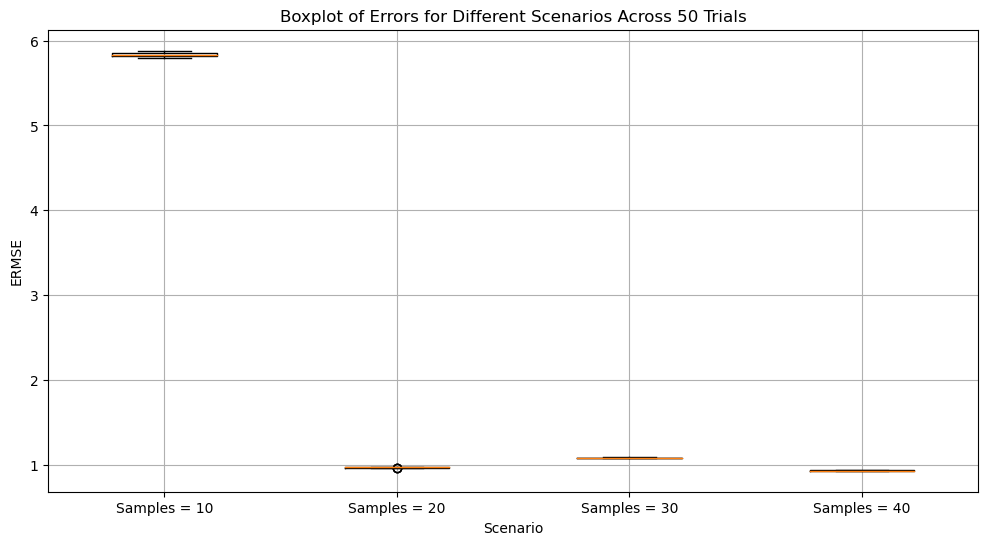

In [89]:
import matplotlib.pyplot as plt

# Assuming you have 4 scenarios and all_metrics is a dictionary of dictionaries
# Format: all_metrics[seed][scenario]

# Prepare data for boxplot
data_runs1 = [[] for _ in range(len(scenarios))]  # Adjust 'len(scenarios)' to the actual number of scenarios you have

for metrics in all_metrics.values():
    for i, n in enumerate(scenarios):
        data_runs1[i].append(metrics[n][1])

# Create boxplots for these runs
plt.figure(figsize=(12, 6))
plt.boxplot(data_runs1, labels=[f"Samples = {n}" for n in scenarios])
plt.title('Boxplot of Errors for Different Scenarios Across 50 Trials')
plt.xlabel('Scenario')
plt.ylabel('ERMSE')
plt.grid(True)
plt.show()


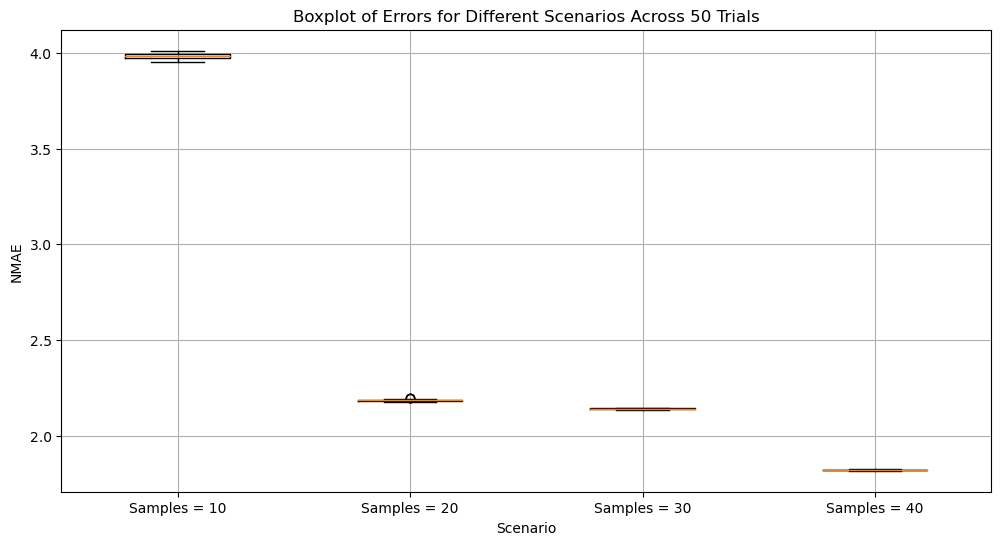

In [90]:
import matplotlib.pyplot as plt

# Assuming you have 4 scenarios and all_metrics is a dictionary of dictionaries
# Format: all_metrics[seed][scenario]

# Prepare data for boxplot
data_runs1 = [[] for _ in range(len(scenarios))]  # Adjust 'len(scenarios)' to the actual number of scenarios you have

for metrics in all_metrics.values():
    for i, n in enumerate(scenarios):
        data_runs1[i].append(metrics[n][2])

# Create boxplots for these runs
plt.figure(figsize=(12, 6))
plt.boxplot(data_runs1, labels=[f"Samples = {n}" for n in scenarios])
plt.title('Boxplot of Errors for Different Scenarios Across 50 Trials')
plt.xlabel('Scenario')
plt.ylabel('NMAE')
plt.grid(True)
plt.show()
